[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [91]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import json
from jax import grad,value_and_grad

# Define the objective function and the gradient of the objective

*   Import the geometry, mesh
*   Build the FEA model
*   Build the SSO model



Import the data needed

In [92]:
#Import the geometry, mesh and fixed node info
f = open('Neumunster.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)


f.close()

df = data['faces'] #Connectivity matrix
faces = np.array(df) #convert to numpy array
df2 = data['vertices'] #Coordinate
crd = np.array(df2) #convert to numpy array
df3 = data['vertex_is_red'] #Connectivity matrix
fixed_nodes = np.where(df3)[0] #convert to numpy array

#From faces to frames
import trimesh
mesh = trimesh.load('Neumunster.ply')

cnct  = np.array(mesh.edges_unique)

In [93]:
#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]-min(crd[:,2])

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [94]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)

fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

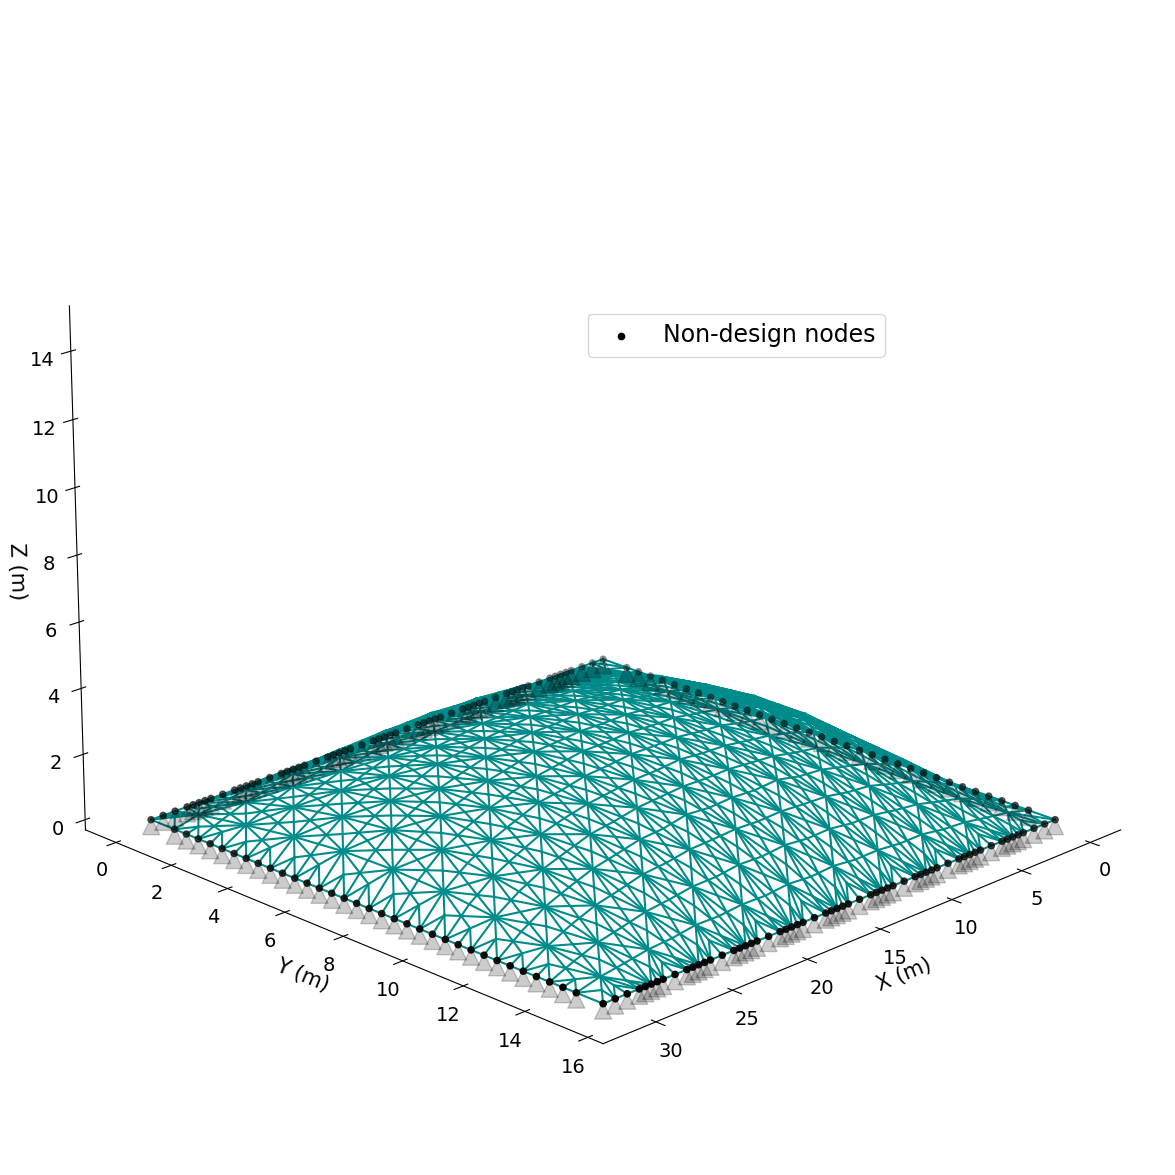

In [95]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,15)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Geodesic info

In [96]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that maximum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    return jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)/jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))

In [97]:
dis_b = dis_boundary(x_nodes,y_nodes,non_design_nodes)[design_nodes]
v_cen = v_centrality(x_nodes,y_nodes,non_design_nodes)[design_nodes]

## Create FEA model

In [98]:
d = 0.1 #diameter
A = np.pi*d**2/4
Iy = np.pi*d**4/64
Iz = np.pi*d**4/64
E = 37900 * 10**5 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
J = Iy + Iz	#Polar moment of inertia
load = 300 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,0,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

aI = 1e-10
#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,aI*Iy,aI*Iz,aI*J,A) 

# SSO model based on FEA model

In [99]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [100]:
%timeit sso_model.value_grad_params(which_solver='dense',enforce_scipy_sparse = True)

The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached.
61.8 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# A simple NN built with Flax

In [101]:
import pymesh
from flax import linen as nn

Input of NN:
vertex crds

Output of NN:
nodal movement (Z)

## Simple Neural Network

In [102]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [107]:
n_input = 4 #(X,Y,dis_b,v_centrality) of each node
n_hidden = 1000 # neurons
n_out = 1 #Z of each node
n_layers =2 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.array([x_nodes[design_nodes],y_nodes[design_nodes],dis_b,v_cen]).T
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [108]:
inp.shape

(1025, 4)

In [109]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [110]:
print(NN)

SimpleNN(
    # attributes
    num_hidden = 1000
    num_outputs = 1
    num_layers = 2
)


In [111]:
import jax
import jax.numpy as jnp  # JAX NumPy


print(NN.tabulate(rng,inp,
                   compute_flops=True, compute_vjp_flops=True))


                                SimpleNN Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs    ┃ outputs  ┃ flops     ┃ vjp_flo… ┃ params    ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━┩
│         │ SimpleNN │ float64[… │ float64… │ 20653582… │ 6194021… │           │
├─────────┼──────────┼───────────┼──────────┼───────────┼──────────┼───────────┤
│ Dense_0 │ Dense    │ float64[… │ float64… │ 9230000   │ 26664000 │ bias:     │
│         │          │           │          │           │          │ float32[… │
│         │          │           │          │           │          │ kernel:   │
│         │          │           │          │           │          │ float32[… │
│         │          │           │          │           │          │           │
│         │          │           │          │           │          │ 5,000     │
│         │          │     

In [112]:
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [113]:
NN.apply(params,inp).reshape(-1).shape

(1025,)

## Optimizer

In [114]:
import optax
optimizer = optax.adamw(learning_rate=0.001,weight_decay=1e-4)

In [115]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

## Loss Function

Pipeline ML with Jax-SSO to get the loss function.

Test if $d(loss)/d(params)$ work

In [116]:
def calculate_loss(state, params, inp):
    
    ##Apply_fn: ML input to output
    z_new = state.apply_fn(params, inp).reshape(-1) #Z-coordinate, ML-Output
    
    #ML output to loss through Jax-SSO
    sso_model.update_nodeparameter(z_new)
    loss = sso_model.params_to_objective()
     
    return loss#+jnp.norm(z_new)


## Training Step and Training

In [117]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [118]:
%timeit train_step(model_state, inp)

290 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [119]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
def train_model(state, num_epochs=2000):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        state, loss = train_step(state, inp)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
    return state

In [120]:
trained_model_state = train_model(model_state, num_epochs=200)

  0%|          | 1/200 [00:00<00:57,  3.44it/s]

Train epoch 2  ,loss:3039679.9221831392


  1%|          | 2/200 [00:00<00:57,  3.46it/s]

Train epoch 3  ,loss:5486879.610384208


  2%|▏         | 3/200 [00:00<00:56,  3.47it/s]

Train epoch 4  ,loss:29560050.64131906


  2%|▏         | 4/200 [00:01<00:56,  3.46it/s]

Train epoch 5  ,loss:2597627.1602207506


  2%|▎         | 5/200 [00:01<00:56,  3.45it/s]

Train epoch 6  ,loss:506472.84992355516


  3%|▎         | 6/200 [00:01<00:56,  3.46it/s]

Train epoch 7  ,loss:422979.9362827941


  4%|▎         | 7/200 [00:02<00:55,  3.46it/s]

Train epoch 8  ,loss:162955.70338861222


  4%|▍         | 8/200 [00:02<00:55,  3.45it/s]

Train epoch 9  ,loss:285020.5420021594


  4%|▍         | 9/200 [00:02<00:55,  3.44it/s]

Train epoch 10  ,loss:778316.6643567306


  5%|▌         | 10/200 [00:02<00:55,  3.44it/s]

Train epoch 11  ,loss:3162743.833032356


  6%|▌         | 11/200 [00:03<00:54,  3.44it/s]

Train epoch 12  ,loss:916786.9323643825


  6%|▌         | 12/200 [00:03<00:54,  3.44it/s]

Train epoch 13  ,loss:1862365.0491495216


  6%|▋         | 13/200 [00:03<00:54,  3.44it/s]

Train epoch 14  ,loss:1027229.9618874934


  7%|▋         | 14/200 [00:04<00:54,  3.43it/s]

Train epoch 15  ,loss:425944.5975270085


  8%|▊         | 15/200 [00:04<00:53,  3.44it/s]

Train epoch 16  ,loss:1714695.3376241527


  8%|▊         | 16/200 [00:04<00:53,  3.44it/s]

Train epoch 17  ,loss:1522639.9605524903


  8%|▊         | 17/200 [00:04<00:53,  3.42it/s]

Train epoch 18  ,loss:648367.5726895106


  9%|▉         | 18/200 [00:05<00:53,  3.42it/s]

Train epoch 19  ,loss:466757.2833338778


 10%|▉         | 19/200 [00:05<00:52,  3.43it/s]

Train epoch 20  ,loss:3020408.281514572


 10%|█         | 20/200 [00:05<00:52,  3.44it/s]

Train epoch 21  ,loss:2151607.9597483003


 10%|█         | 21/200 [00:06<00:52,  3.44it/s]

Train epoch 22  ,loss:380643.1208575923


 11%|█         | 22/200 [00:06<00:51,  3.44it/s]

Train epoch 23  ,loss:2048392.5716266858


 12%|█▏        | 23/200 [00:06<00:51,  3.43it/s]

Train epoch 24  ,loss:786487.2470390355


 12%|█▏        | 24/200 [00:06<00:51,  3.43it/s]

Train epoch 25  ,loss:620330.2846544853


 12%|█▎        | 25/200 [00:07<00:51,  3.43it/s]

Train epoch 26  ,loss:2448694.658309896


 13%|█▎        | 26/200 [00:07<00:50,  3.43it/s]

Train epoch 27  ,loss:309959.17538740695


 14%|█▎        | 27/200 [00:07<00:50,  3.43it/s]

Train epoch 28  ,loss:1012634.223907623


 14%|█▍        | 28/200 [00:08<00:50,  3.44it/s]

Train epoch 29  ,loss:825748.2251922659


 14%|█▍        | 29/200 [00:08<00:49,  3.44it/s]

Train epoch 30  ,loss:1179634.3536906946


 15%|█▌        | 30/200 [00:08<00:49,  3.44it/s]

Train epoch 31  ,loss:1317729.5365625573


 16%|█▌        | 31/200 [00:09<00:49,  3.43it/s]

Train epoch 32  ,loss:122902.17571417475


 16%|█▌        | 32/200 [00:09<00:48,  3.44it/s]

Train epoch 33  ,loss:10534033.801536273


 16%|█▋        | 33/200 [00:09<00:48,  3.44it/s]

Train epoch 34  ,loss:187439.00595190152


 17%|█▋        | 34/200 [00:09<00:48,  3.44it/s]

Train epoch 35  ,loss:1861749.790387317


 18%|█▊        | 35/200 [00:10<00:47,  3.45it/s]

Train epoch 36  ,loss:1163349.3880641083


 18%|█▊        | 36/200 [00:10<00:47,  3.44it/s]

Train epoch 37  ,loss:621910.1894218193


 18%|█▊        | 37/200 [00:10<00:47,  3.45it/s]

Train epoch 38  ,loss:1583034.4842304857


 19%|█▉        | 38/200 [00:11<00:46,  3.45it/s]

Train epoch 39  ,loss:973368.9421787271


 20%|█▉        | 39/200 [00:11<00:46,  3.46it/s]

Train epoch 40  ,loss:3160261.080520855


 20%|██        | 40/200 [00:11<00:46,  3.46it/s]

Train epoch 41  ,loss:802040.9253657553


 20%|██        | 41/200 [00:11<00:45,  3.47it/s]

Train epoch 42  ,loss:3382686.3613332347


 21%|██        | 42/200 [00:12<00:45,  3.46it/s]

Train epoch 43  ,loss:1539263.043440002


 22%|██▏       | 43/200 [00:12<00:45,  3.46it/s]

Train epoch 44  ,loss:22168133.593977503


 22%|██▏       | 44/200 [00:12<00:45,  3.45it/s]

Train epoch 45  ,loss:1291195.6340720665


 22%|██▎       | 45/200 [00:13<00:44,  3.45it/s]

Train epoch 46  ,loss:748149.3032669476


 23%|██▎       | 46/200 [00:13<00:44,  3.46it/s]

Train epoch 47  ,loss:1924623.6314360362


 24%|██▎       | 47/200 [00:13<00:44,  3.46it/s]

Train epoch 48  ,loss:652728.7542712366


 24%|██▍       | 48/200 [00:13<00:43,  3.46it/s]

Train epoch 49  ,loss:497372.9630429977


 24%|██▍       | 49/200 [00:14<00:43,  3.47it/s]

Train epoch 50  ,loss:651243.3758998951


 25%|██▌       | 50/200 [00:14<00:43,  3.47it/s]

Train epoch 51  ,loss:1101846.796742286


 26%|██▌       | 51/200 [00:14<00:42,  3.47it/s]

Train epoch 52  ,loss:717118.242252324


 26%|██▌       | 52/200 [00:15<00:42,  3.48it/s]

Train epoch 53  ,loss:609824.93208108


 26%|██▋       | 53/200 [00:15<00:42,  3.48it/s]

Train epoch 54  ,loss:499126.5212818726


 27%|██▋       | 54/200 [00:15<00:42,  3.47it/s]

Train epoch 55  ,loss:2260800.682923775


 28%|██▊       | 55/200 [00:15<00:41,  3.47it/s]

Train epoch 56  ,loss:657103.7323995344


 28%|██▊       | 56/200 [00:16<00:41,  3.47it/s]

Train epoch 57  ,loss:696927.48424193


 28%|██▊       | 57/200 [00:16<00:41,  3.47it/s]

Train epoch 58  ,loss:643529.4046927365


 29%|██▉       | 58/200 [00:16<00:40,  3.47it/s]

Train epoch 59  ,loss:780843.2551440828


 30%|██▉       | 59/200 [00:17<00:40,  3.47it/s]

Train epoch 60  ,loss:769396.7352572646


 30%|███       | 60/200 [00:17<00:40,  3.45it/s]

Train epoch 61  ,loss:539257.3373247024


 30%|███       | 61/200 [00:17<00:40,  3.46it/s]

Train epoch 62  ,loss:408882.60987205553


 31%|███       | 62/200 [00:17<00:39,  3.46it/s]

Train epoch 63  ,loss:395964.3877865943


 32%|███▏      | 63/200 [00:18<00:39,  3.47it/s]

Train epoch 64  ,loss:402017.87404716853


 32%|███▏      | 64/200 [00:18<00:39,  3.47it/s]

Train epoch 65  ,loss:406299.3680785629


 32%|███▎      | 65/200 [00:18<00:38,  3.47it/s]

Train epoch 66  ,loss:393790.6836772615


 33%|███▎      | 66/200 [00:19<00:38,  3.47it/s]

Train epoch 67  ,loss:370000.2738682948


 34%|███▎      | 67/200 [00:19<00:38,  3.46it/s]

Train epoch 68  ,loss:325643.76545470895


 34%|███▍      | 68/200 [00:19<00:38,  3.45it/s]

Train epoch 69  ,loss:292275.3141846736


 34%|███▍      | 69/200 [00:19<00:37,  3.46it/s]

Train epoch 70  ,loss:289022.5263582795


 35%|███▌      | 70/200 [00:20<00:37,  3.46it/s]

Train epoch 71  ,loss:294081.2038368115


 36%|███▌      | 71/200 [00:20<00:37,  3.46it/s]

Train epoch 72  ,loss:300577.9148146665


 36%|███▌      | 72/200 [00:20<00:36,  3.46it/s]

Train epoch 73  ,loss:302253.3548020851


 36%|███▋      | 73/200 [00:21<00:37,  3.41it/s]

Train epoch 74  ,loss:301969.9053259528


 37%|███▋      | 74/200 [00:21<00:36,  3.43it/s]

Train epoch 75  ,loss:299428.71867393283


 38%|███▊      | 75/200 [00:21<00:36,  3.44it/s]

Train epoch 76  ,loss:293867.64345060714


 38%|███▊      | 76/200 [00:22<00:36,  3.44it/s]

Train epoch 77  ,loss:288671.62178490404


 38%|███▊      | 77/200 [00:22<00:35,  3.45it/s]

Train epoch 78  ,loss:281932.12004115526


 39%|███▉      | 78/200 [00:22<00:35,  3.46it/s]

Train epoch 79  ,loss:278962.2144886094


 40%|███▉      | 79/200 [00:22<00:35,  3.45it/s]

Train epoch 80  ,loss:278890.0507572638


 40%|████      | 80/200 [00:23<00:34,  3.46it/s]

Train epoch 81  ,loss:282323.8230148826


 40%|████      | 81/200 [00:23<00:34,  3.46it/s]

Train epoch 82  ,loss:280381.16943732393


 41%|████      | 82/200 [00:23<00:34,  3.46it/s]

Train epoch 83  ,loss:267589.95497442334


 42%|████▏     | 83/200 [00:24<00:33,  3.46it/s]

Train epoch 84  ,loss:263477.699200012


 42%|████▏     | 84/200 [00:24<00:33,  3.46it/s]

Train epoch 85  ,loss:259163.8969235663


 42%|████▎     | 85/200 [00:24<00:33,  3.46it/s]

Train epoch 86  ,loss:252770.1564031365


 43%|████▎     | 86/200 [00:24<00:32,  3.46it/s]

Train epoch 87  ,loss:244359.3384050288


 44%|████▎     | 87/200 [00:25<00:32,  3.47it/s]

Train epoch 88  ,loss:235024.18444484635


 44%|████▍     | 88/200 [00:25<00:32,  3.47it/s]

Train epoch 89  ,loss:226233.86287687527


 44%|████▍     | 89/200 [00:25<00:31,  3.47it/s]

Train epoch 90  ,loss:218538.95852395066


 45%|████▌     | 90/200 [00:26<00:31,  3.48it/s]

Train epoch 91  ,loss:210861.2067248649


 46%|████▌     | 91/200 [00:26<00:31,  3.45it/s]

Train epoch 92  ,loss:203658.3926559695


 46%|████▌     | 92/200 [00:26<00:31,  3.46it/s]

Train epoch 93  ,loss:199152.13978660648


 46%|████▋     | 93/200 [00:26<00:30,  3.46it/s]

Train epoch 94  ,loss:194996.20104245178


 47%|████▋     | 94/200 [00:27<00:30,  3.47it/s]

Train epoch 95  ,loss:191580.4325769368


 48%|████▊     | 95/200 [00:27<00:30,  3.46it/s]

Train epoch 96  ,loss:188130.81469970694


 48%|████▊     | 96/200 [00:27<00:30,  3.46it/s]

Train epoch 97  ,loss:185035.69723030168


 48%|████▊     | 97/200 [00:28<00:29,  3.45it/s]

Train epoch 98  ,loss:182457.85729169694


 49%|████▉     | 98/200 [00:28<00:29,  3.46it/s]

Train epoch 99  ,loss:180147.4552472406


 50%|████▉     | 99/200 [00:28<00:29,  3.46it/s]

Train epoch 100  ,loss:178030.7088055452


 50%|█████     | 100/200 [00:28<00:28,  3.46it/s]

Train epoch 101  ,loss:176069.0308969981


 50%|█████     | 101/200 [00:29<00:28,  3.46it/s]

Train epoch 102  ,loss:174335.10839371808


 51%|█████     | 102/200 [00:29<00:28,  3.46it/s]

Train epoch 103  ,loss:172799.58575079523


 52%|█████▏    | 103/200 [00:29<00:28,  3.46it/s]

Train epoch 104  ,loss:171394.68940154064


 52%|█████▏    | 104/200 [00:30<00:27,  3.47it/s]

Train epoch 105  ,loss:170056.0790635586


 52%|█████▎    | 105/200 [00:30<00:27,  3.47it/s]

Train epoch 106  ,loss:168780.56224040443


 53%|█████▎    | 106/200 [00:30<00:27,  3.46it/s]

Train epoch 107  ,loss:167564.76424281392


 54%|█████▎    | 107/200 [00:30<00:26,  3.47it/s]

Train epoch 108  ,loss:166405.15581493685


 54%|█████▍    | 108/200 [00:31<00:26,  3.47it/s]

Train epoch 109  ,loss:165298.7286342536


 55%|█████▍    | 109/200 [00:31<00:26,  3.47it/s]

Train epoch 110  ,loss:164242.86990608327


 55%|█████▌    | 110/200 [00:31<00:25,  3.47it/s]

Train epoch 111  ,loss:163216.7933836587


 56%|█████▌    | 111/200 [00:32<00:25,  3.47it/s]

Train epoch 112  ,loss:162242.62696310694


 56%|█████▌    | 112/200 [00:32<00:25,  3.47it/s]

Train epoch 113  ,loss:161323.83759653804


 56%|█████▋    | 113/200 [00:32<00:25,  3.47it/s]

Train epoch 114  ,loss:160442.48175245928


 57%|█████▋    | 114/200 [00:32<00:24,  3.46it/s]

Train epoch 115  ,loss:159647.34200142257


 57%|█████▊    | 115/200 [00:33<00:24,  3.46it/s]

Train epoch 116  ,loss:158880.0860323773


 58%|█████▊    | 116/200 [00:33<00:24,  3.45it/s]

Train epoch 117  ,loss:158138.60251271946


 58%|█████▊    | 117/200 [00:33<00:24,  3.45it/s]

Train epoch 118  ,loss:157415.78293164924


 59%|█████▉    | 118/200 [00:34<00:23,  3.45it/s]

Train epoch 119  ,loss:156708.2382027253


 60%|█████▉    | 119/200 [00:34<00:23,  3.46it/s]

Train epoch 120  ,loss:156016.4210349567


 60%|██████    | 120/200 [00:34<00:23,  3.45it/s]

Train epoch 121  ,loss:155338.07497220454


 60%|██████    | 121/200 [00:35<00:22,  3.46it/s]

Train epoch 122  ,loss:154675.12109507003


 61%|██████    | 122/200 [00:35<00:22,  3.45it/s]

Train epoch 123  ,loss:154026.9650087639


 62%|██████▏   | 123/200 [00:35<00:22,  3.46it/s]

Train epoch 124  ,loss:153406.5167009842


 62%|██████▏   | 124/200 [00:35<00:21,  3.46it/s]

Train epoch 125  ,loss:152802.52792453032


 62%|██████▎   | 125/200 [00:36<00:21,  3.46it/s]

Train epoch 126  ,loss:152214.03519919136


 63%|██████▎   | 126/200 [00:36<00:21,  3.47it/s]

Train epoch 127  ,loss:151641.81301017752


 64%|██████▎   | 127/200 [00:36<00:21,  3.47it/s]

Train epoch 128  ,loss:151087.82361679315


 64%|██████▍   | 128/200 [00:37<00:20,  3.47it/s]

Train epoch 129  ,loss:150551.3406718856


 64%|██████▍   | 129/200 [00:37<00:20,  3.47it/s]

Train epoch 130  ,loss:150043.3661740364


 65%|██████▌   | 130/200 [00:37<00:20,  3.47it/s]

Train epoch 131  ,loss:149547.4831461152


 66%|██████▌   | 131/200 [00:37<00:19,  3.46it/s]

Train epoch 132  ,loss:149064.18527592707


 66%|██████▌   | 132/200 [00:38<00:19,  3.45it/s]

Train epoch 133  ,loss:148591.2199934002


 66%|██████▋   | 133/200 [00:38<00:19,  3.46it/s]

Train epoch 134  ,loss:148129.3973620177


 67%|██████▋   | 134/200 [00:38<00:19,  3.45it/s]

Train epoch 135  ,loss:147676.60663606305


 68%|██████▊   | 135/200 [00:39<00:18,  3.46it/s]

Train epoch 136  ,loss:147225.38734194994


 68%|██████▊   | 136/200 [00:39<00:18,  3.46it/s]

Train epoch 137  ,loss:146782.97801784743


 68%|██████▊   | 137/200 [00:39<00:18,  3.46it/s]

Train epoch 138  ,loss:146357.61796050332


 69%|██████▉   | 138/200 [00:39<00:17,  3.46it/s]

Train epoch 139  ,loss:145944.67916878953


 70%|██████▉   | 139/200 [00:40<00:17,  3.47it/s]

Train epoch 140  ,loss:145540.40200749994


 70%|███████   | 140/200 [00:40<00:17,  3.46it/s]

Train epoch 141  ,loss:145145.61170273199


 70%|███████   | 141/200 [00:40<00:17,  3.46it/s]

Train epoch 142  ,loss:144760.24369591218


 71%|███████   | 142/200 [00:41<00:16,  3.47it/s]

Train epoch 143  ,loss:144383.42078236965


 72%|███████▏  | 143/200 [00:41<00:16,  3.47it/s]

Train epoch 144  ,loss:144001.66138670483


 72%|███████▏  | 144/200 [00:41<00:16,  3.46it/s]

Train epoch 145  ,loss:143630.3282524145


 72%|███████▎  | 145/200 [00:41<00:15,  3.47it/s]

Train epoch 146  ,loss:143268.76754859556


 73%|███████▎  | 146/200 [00:42<00:15,  3.46it/s]

Train epoch 147  ,loss:142914.1290505326


 74%|███████▎  | 147/200 [00:42<00:15,  3.46it/s]

Train epoch 148  ,loss:142564.00706233433


 74%|███████▍  | 148/200 [00:42<00:15,  3.46it/s]

Train epoch 149  ,loss:142216.89498662727


 74%|███████▍  | 149/200 [00:43<00:14,  3.46it/s]

Train epoch 150  ,loss:141873.46139721508


 75%|███████▌  | 150/200 [00:43<00:14,  3.47it/s]

Train epoch 151  ,loss:141536.63258207246


 76%|███████▌  | 151/200 [00:43<00:14,  3.47it/s]

Train epoch 152  ,loss:141200.92431143965


 76%|███████▌  | 152/200 [00:43<00:13,  3.46it/s]

Train epoch 153  ,loss:140868.13111481856


 76%|███████▋  | 153/200 [00:44<00:13,  3.46it/s]

Train epoch 154  ,loss:140541.811779232


 77%|███████▋  | 154/200 [00:44<00:13,  3.47it/s]

Train epoch 155  ,loss:140217.81703479966


 78%|███████▊  | 155/200 [00:44<00:12,  3.47it/s]

Train epoch 156  ,loss:139896.92551670823


 78%|███████▊  | 156/200 [00:45<00:12,  3.47it/s]

Train epoch 157  ,loss:139579.00337556144


 78%|███████▊  | 157/200 [00:45<00:12,  3.47it/s]

Train epoch 158  ,loss:139265.1066308934


 79%|███████▉  | 158/200 [00:45<00:12,  3.47it/s]

Train epoch 159  ,loss:138963.3336795773


 80%|███████▉  | 159/200 [00:45<00:11,  3.46it/s]

Train epoch 160  ,loss:138666.23745222302


 80%|████████  | 160/200 [00:46<00:11,  3.47it/s]

Train epoch 161  ,loss:138365.9739375623


 80%|████████  | 161/200 [00:46<00:11,  3.47it/s]

Train epoch 162  ,loss:138069.10957444445


 81%|████████  | 162/200 [00:46<00:10,  3.48it/s]

Train epoch 163  ,loss:137772.39959353453


 82%|████████▏ | 163/200 [00:47<00:10,  3.48it/s]

Train epoch 164  ,loss:137480.29110298332


 82%|████████▏ | 164/200 [00:47<00:10,  3.47it/s]

Train epoch 165  ,loss:137191.20506336563


 82%|████████▎ | 165/200 [00:47<00:10,  3.47it/s]

Train epoch 166  ,loss:136903.77821436187


 83%|████████▎ | 166/200 [00:48<00:09,  3.46it/s]

Train epoch 167  ,loss:136624.91220652923


 84%|████████▎ | 167/200 [00:48<00:09,  3.47it/s]

Train epoch 168  ,loss:136349.77358621353


 84%|████████▍ | 168/200 [00:48<00:09,  3.46it/s]

Train epoch 169  ,loss:136077.1947981281


 84%|████████▍ | 169/200 [00:48<00:08,  3.46it/s]

Train epoch 170  ,loss:135807.60455208633


 85%|████████▌ | 170/200 [00:49<00:08,  3.46it/s]

Train epoch 171  ,loss:135541.7480026056


 86%|████████▌ | 171/200 [00:49<00:08,  3.45it/s]

Train epoch 172  ,loss:135278.48563534993


 86%|████████▌ | 172/200 [00:49<00:08,  3.46it/s]

Train epoch 173  ,loss:135016.77577253708


 86%|████████▋ | 173/200 [00:50<00:07,  3.45it/s]

Train epoch 174  ,loss:134757.02125175897


 87%|████████▋ | 174/200 [00:50<00:07,  3.46it/s]

Train epoch 175  ,loss:134499.04966673933


 88%|████████▊ | 175/200 [00:50<00:07,  3.46it/s]

Train epoch 176  ,loss:134245.96367490478


 88%|████████▊ | 176/200 [00:50<00:06,  3.47it/s]

Train epoch 177  ,loss:133997.33149784038


 88%|████████▊ | 177/200 [00:51<00:06,  3.41it/s]

Train epoch 178  ,loss:133751.82865331834


 89%|████████▉ | 178/200 [00:51<00:06,  3.42it/s]

Train epoch 179  ,loss:133507.75013955552


 90%|████████▉ | 179/200 [00:51<00:06,  3.44it/s]

Train epoch 180  ,loss:133267.45558131923


 90%|█████████ | 180/200 [00:52<00:05,  3.43it/s]

Train epoch 181  ,loss:133030.36313275842


 90%|█████████ | 181/200 [00:52<00:05,  3.44it/s]

Train epoch 182  ,loss:132794.60912515558


 91%|█████████ | 182/200 [00:52<00:05,  3.44it/s]

Train epoch 183  ,loss:132560.22580172494


 92%|█████████▏| 183/200 [00:52<00:04,  3.45it/s]

Train epoch 184  ,loss:132327.09586757564


 92%|█████████▏| 184/200 [00:53<00:04,  3.44it/s]

Train epoch 185  ,loss:132095.82656830456


 92%|█████████▎| 185/200 [00:53<00:04,  3.44it/s]

Train epoch 186  ,loss:131866.03955383322


 93%|█████████▎| 186/200 [00:53<00:04,  3.44it/s]

Train epoch 187  ,loss:131639.5331500824


 94%|█████████▎| 187/200 [00:54<00:03,  3.45it/s]

Train epoch 188  ,loss:131417.8782902313


 94%|█████████▍| 188/200 [00:54<00:03,  3.46it/s]

Train epoch 189  ,loss:131196.8626413573


 94%|█████████▍| 189/200 [00:54<00:03,  3.45it/s]

Train epoch 190  ,loss:130978.96174885458


 95%|█████████▌| 190/200 [00:54<00:02,  3.45it/s]

Train epoch 191  ,loss:130762.12620649075


 96%|█████████▌| 191/200 [00:55<00:02,  3.46it/s]

Train epoch 192  ,loss:130549.48218259653


 96%|█████████▌| 192/200 [00:55<00:02,  3.46it/s]

Train epoch 193  ,loss:130335.62348785745


 96%|█████████▋| 193/200 [00:55<00:02,  3.46it/s]

Train epoch 194  ,loss:130124.13732841116


 97%|█████████▋| 194/200 [00:56<00:01,  3.47it/s]

Train epoch 195  ,loss:129911.31284764549


 98%|█████████▊| 195/200 [00:56<00:01,  3.46it/s]

Train epoch 196  ,loss:129697.37743440346


 98%|█████████▊| 196/200 [00:56<00:01,  3.46it/s]

Train epoch 197  ,loss:129484.30280492327


 98%|█████████▊| 197/200 [00:56<00:00,  3.46it/s]

Train epoch 198  ,loss:129271.76094226251


 99%|█████████▉| 198/200 [00:57<00:00,  3.47it/s]

Train epoch 199  ,loss:129059.81770803989


100%|█████████▉| 199/200 [00:57<00:00,  3.46it/s]

Train epoch 200  ,loss:128849.7610202709


100%|██████████| 200/200 [00:57<00:00,  3.46it/s]

Train epoch 201  ,loss:128641.17515590775


# This example does not make too much engineering sense: it is essentially gradient descent with FEA+ANN. But it shows how simple it is to incorporate JaxSSO in ML framework.

In [123]:
##Apply_fn: ML input to output
z_new = trained_model_state.apply_fn(trained_model_state.params, inp).reshape(-1) #how to move nodes along z, ML-Outpu

#ML output to loss through Jax-SSO
z_nodes[design_nodes] = -z_new

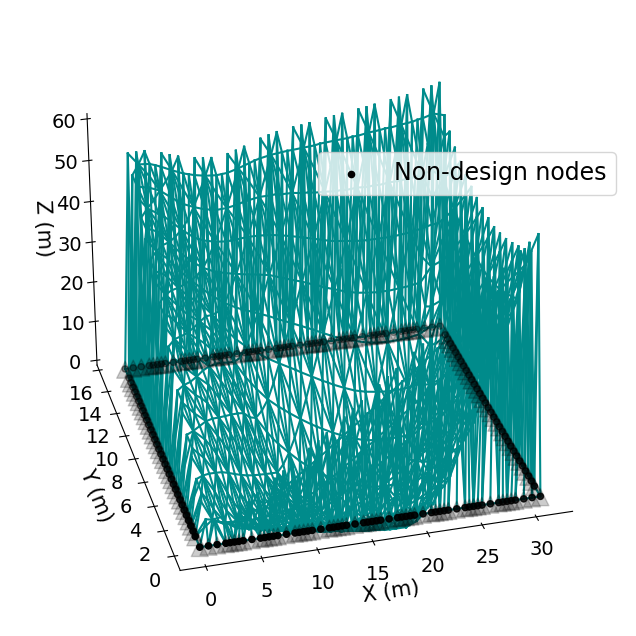

In [124]:
#Update the nodes
%matplotlib inline
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,60)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()